# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as mcolors

# Util

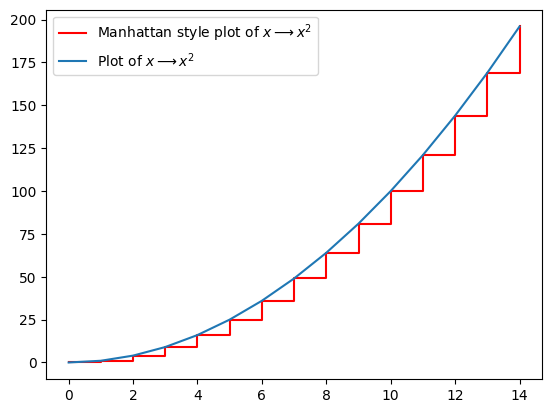

In [3]:
def plot_manhattan_style(array,ax,**plot_kwargs):
    n = len(array)
    x = [0]
    y = [array[0]]
    index= 1
    while index <n:
      if array[index]!=array[index-1]:
        x.append(index)
        x.append(index)
        y.append(array[index-1])
        y.append(array[index])
      else:
        x.append(index)
        y.append(array[index])
      index+=1
    ax.plot(x,y,**plot_kwargs)
    return ax

a = np.array(range(15)) **2
_,ax = plt.subplots(1,1)
plot_manhattan_style(a,ax,color="red",label="Manhattan style plot of $x\longrightarrow x^2$")
ax.plot(a,label="Plot of $x\longrightarrow x^2$")
ax.legend()
plt.show()

# Simulating Brownian motion

In [4]:
def generate_one_path_multiple_assets(n_assets: int, covariance_matrix: np.ndarray, drift_vector: np.ndarray, S0_vector: np.ndarray, N: int):
    """
    From market parameters for n_assets stocks, such as drift and volatility,
    output a sample path for the n_assets with N timesteps (result should be a matrix of size N*n_assets)
    """
    dt = 1 / N

    Z_in_N_0_sigma2_ij = np.random.multivariate_normal([0.] * n_assets, covariance_matrix, N)# if n_assets>1 else np.random.normal(0.,covariance_matrix[0],size=(N))

    sigma_vector = np.sqrt(np.diag(covariance_matrix))

    tile_r_vector = np.tile(drift_vector - sigma_vector * sigma_vector / 2, (N, 1))
    tile_sigma_vector = np.tile(sigma_vector, (N, 1))
    tile_S0_vector = np.tile(S0_vector, (N, 1))

    dW_sigma2_ij = np.sqrt(dt) * Z_in_N_0_sigma2_ij
    cumprod_exp = np.exp(tile_r_vector * dt + dW_sigma2_ij).cumprod(axis=0)

    return tile_S0_vector * cumprod_exp

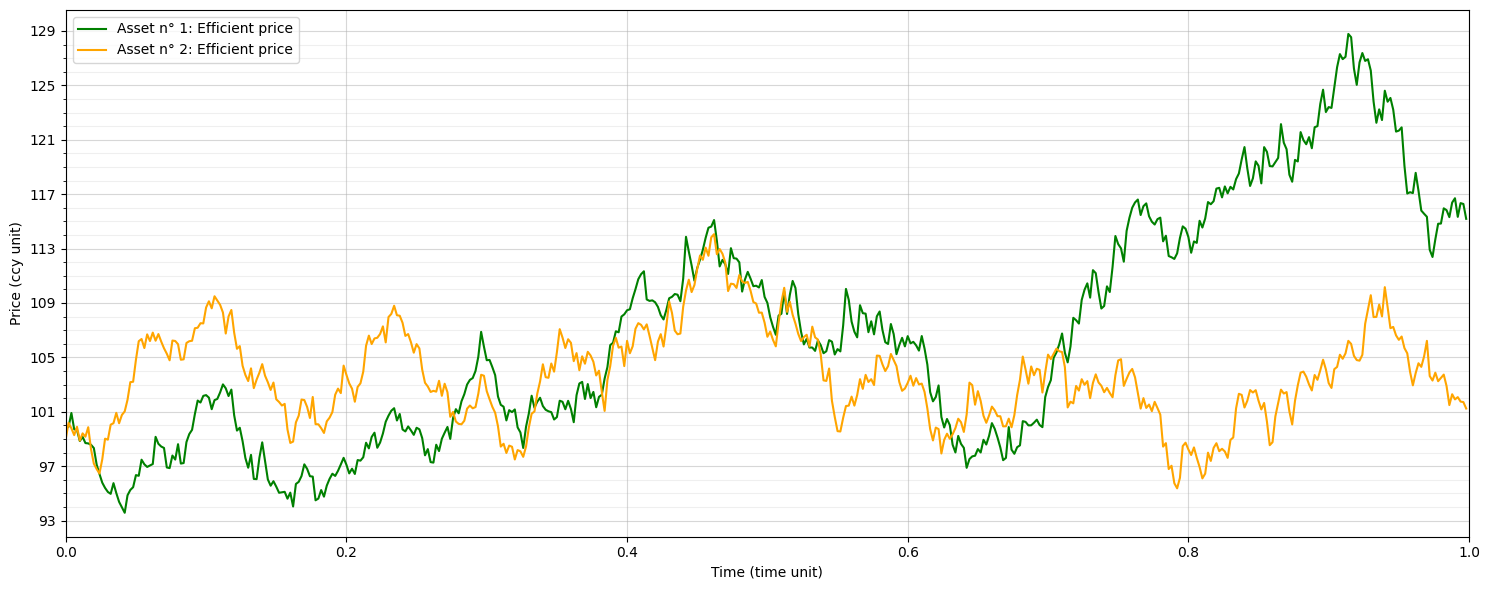

In [5]:
n_assets = 2

drift = .05
S0 = 100.
N = 500
rho = 0.5
sigma = 0.2
cov = sigma * sigma * rho

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

t_array = np.array(range(N))/N

gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix,drift_vector = drift_vector,S0_vector = S0_vector, N=N)

colors = ["green","orange"]

tick_size = S0/ 100.

fig,ax = plt.subplots(1,1,figsize=(15,6))
for index,(raw_price,color) in enumerate(zip(gen_prices.T,colors)):
  ax.plot(t_array,raw_price,color=color,label=f"Asset n° {index+1}: Efficient price")
ax.grid(True)
ax.set_ylabel("Price (ccy unit)")
ax.set_xlabel("Time (time unit)")
ax.legend()
# fig.suptitle(f"Parameters for the simulation : $S_0={S0},\sigma={sigma},\\rho={rho},r={drift},N={N}$",fontsize = 16)

padding = 0.005
min_plot = gen_prices.min()*(1-padding)
min_plot = tick_size * min_plot//tick_size
max_plot = gen_prices.max()*(1+padding)
max_plot = tick_size * (max_plot+1)//tick_size
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange( min_plot, max_plot , tick_size * 4)
minor_ticks = np.arange( min_plot, max_plot , tick_size)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_xlim((0,1.))

plt.tight_layout()

plt.show()

# Uncertainty zones

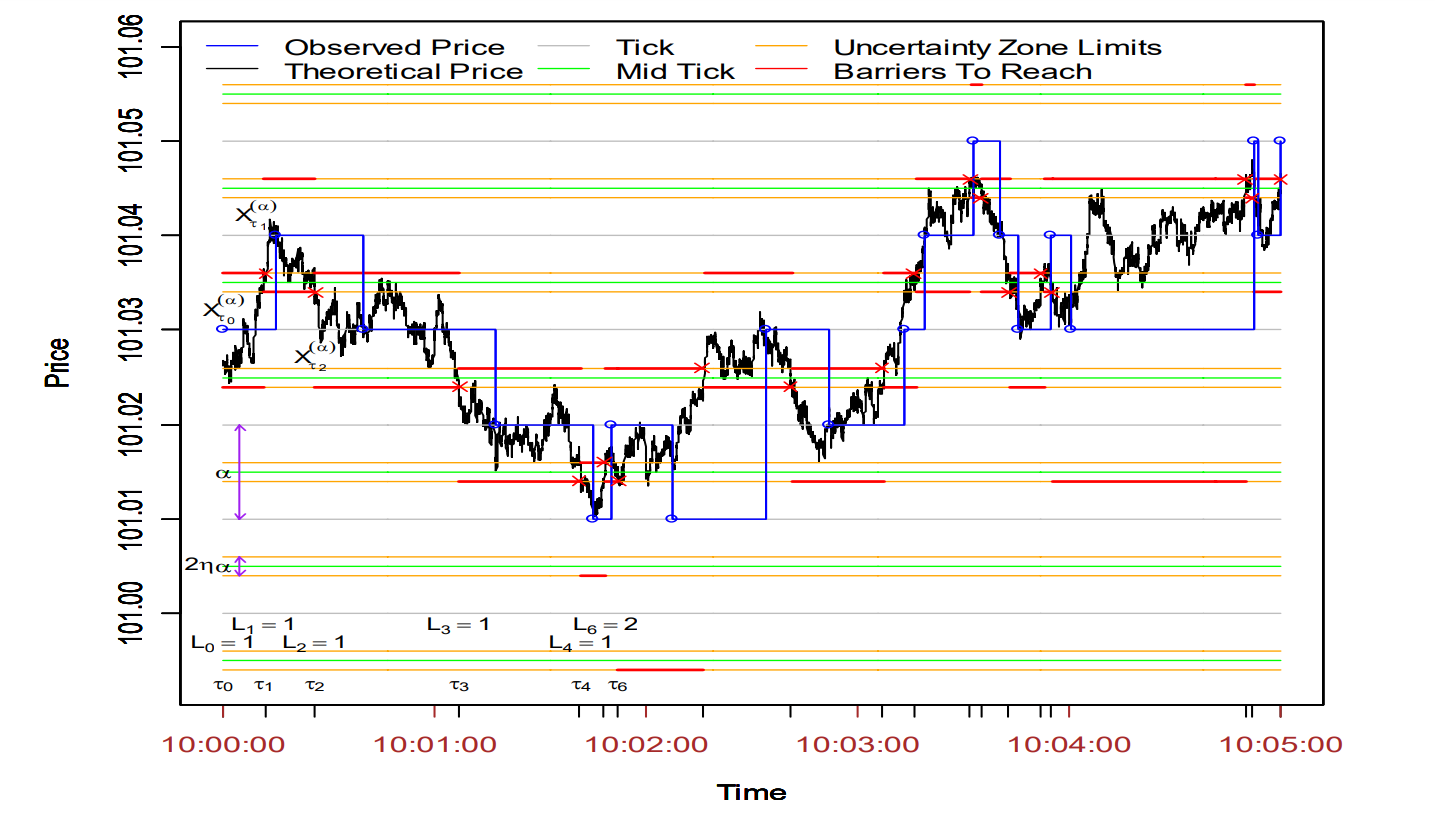

In [6]:
def get_observed_price_from_theoritical_price(theoretical_price:np.ndarray,tick_size : float,eta : float):

  observed_price = np.zeros_like(theoretical_price)

  min_plot = tick_size * theoretical_price.min()//tick_size - tick_size
  max_plot = tick_size * theoretical_price.max()//tick_size + tick_size
  half_tick = np.arange( min_plot, max_plot , tick_size)
  limits = np.array([t + eta * tick_size for t in half_tick] + [t - eta * tick_size for t in half_tick])

  observed_price[0] = np.round(theoretical_price[0] / tick_size) * tick_size

  previous_limits = np.zeros_like(theoretical_price)
  for step in range(1,len(observed_price)):
    limits_up = observed_price[step-1] + tick_size* (1/2 + eta)
    limits_down = observed_price[step-1] - tick_size* (1/2 + eta)

    tick_up_from_theo_price = tick_size * (theoretical_price[step]//tick_size+1)
    tick_down_from_theo_price = tick_size * (theoretical_price[step]//tick_size)

    observed_price[step] = observed_price[step-1]
    observed_price[step] = np.where(theoretical_price[step]>limits_up,tick_up_from_theo_price,observed_price[step])
    observed_price[step] = np.where(theoretical_price[step]<limits_down,tick_down_from_theo_price,observed_price[step])
    
  return observed_price

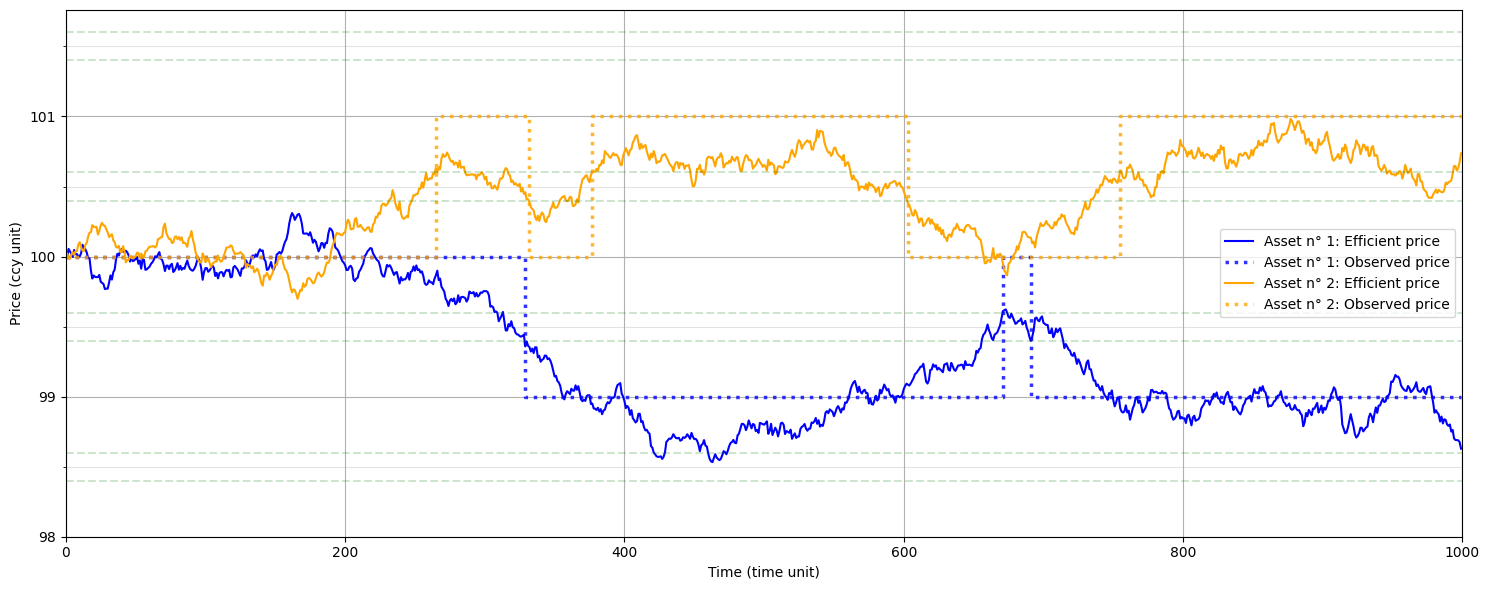

In [7]:
n_assets = 2

drift = .0
S0 = 100.
N = 1000
rho = -0.5
sigma = 0.01
cov = sigma * sigma * rho

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix,drift_vector = drift_vector,S0_vector = S0_vector, N=N)

colors = ["blue","orange"]

tick_size = S0/ 100.
eta = 0.1

ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)

fig,ax = plt.subplots(1,1,figsize=(15,6))

for index,(raw_price,ticked_price,color) in enumerate(zip(gen_prices.T,ticked_prices.T,colors)):
  ax.plot(raw_price,color=color,label=f"Asset n° {index+1}: Efficient price")
  plot_manhattan_style(array = ticked_price,ax=ax,color=color,linestyle=":",label=f"Asset n° {index+1}: Observed price",alpha=.8,linewidth =2.5)
ax.grid(True)
ax.set_ylabel("Price (ccy unit)")
ax.set_xlabel("Time (time unit)")
ax.legend()
# fig.suptitle(f"Parameters for the simulation : $S_0={S0},\sigma={sigma},\\rho={rho},r={drift},N={N},\\alpha={tick_size},\eta={eta}$",fontsize = 16)

padding = 0.005
min_plot = gen_prices.min()*(1-padding)
min_plot = tick_size * min_plot//tick_size
max_plot = gen_prices.max()*(1+padding)
max_plot = tick_size * (max_plot+1)//tick_size

whole_tick = np.arange( min_plot, max_plot , tick_size)
half_tick = np.arange( min_plot, max_plot , tick_size/2)

for half_tick_y in half_tick[1::2]:
  ax.axhline(half_tick_y - eta * tick_size,linestyle="--",color="green",alpha = .2)
  ax.axhline(half_tick_y + eta * tick_size,linestyle="--",color="green",alpha = .2)

ax.set_yticks(whole_tick)
ax.set_yticks(half_tick, minor=True)

ax.grid(which='minor', alpha=0.35)
ax.grid(which='major', alpha=1.)

ax.set_xlim((0,N))

plt.tight_layout()

plt.show()

# Correlation and covariance estimation

In [8]:
def plot_mc_on_ax(ax,data_list : list, x:float,N_sim_sqrt : float , label : str):

  data_mean = np.mean(data_list)
  data_std = np.std(data_list)

  ax.scatter(x,data_mean,color="red",label=label,marker="x")
  ax.vlines(x = x,ymin = data_mean - data_std * 3 / N_sim_sqrt, ymax = data_mean + data_std * 3 / N_sim_sqrt,alpha=.25,linestyle="dashed",label="99% Confidence Interval")
  ax.scatter(x, data_mean - data_std * 3 / N_sim_sqrt,marker = "o",color="blue",alpha=.5)
  ax.scatter(x, data_mean + data_std * 3 / N_sim_sqrt,marker = "o",color="blue",alpha=.5)

  handles0, labels0 = ax.get_legend_handles_labels()
  ax.legend(handles0[:2],labels0[:2],)

## $\hat{\rho_h}$ estimator for constant volatility

In [9]:
def compute_rho_estimator_constant_volatility(prices_bar: np.ndarray):

    log_returns_x = np.diff(np.log(prices_bar[:,0]))
    log_returns_y = np.diff(np.log(prices_bar[:,1]))

    cn_hat = np.sum(log_returns_x * log_returns_y)
    rho_estimator = cn_hat / np.sqrt(np.sum(log_returns_x * log_returns_x) * np.sum(log_returns_y * log_returns_y))

    return rho_estimator

100%|██████████| 6/6 [00:18<00:00,  3.14s/it]


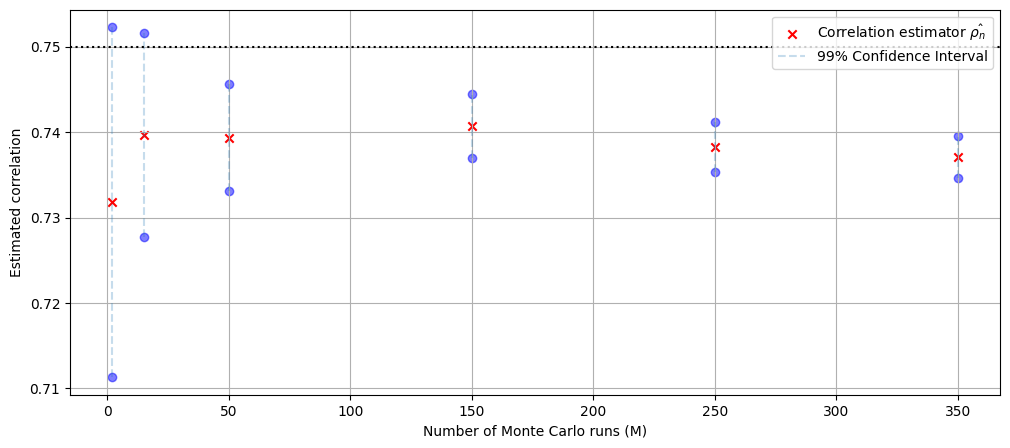

In [10]:
n_assets = 2

drift = .05
S0 = 100.
N = 1000
rho = 0.75
sigma = 0.25
cov = sigma * sigma * rho

tick_size = S0/ 500.
eta = 0.1

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

fig,ax = plt.subplots(1,1,figsize=(12,5))

N_sim_list = [2,15,50,150,250,350]

for N_sim in tqdm(N_sim_list):
  correl_hat = []
  N_sim_sqrt = np.sqrt(N_sim)
  for _ in range(1,N_sim+1):
    gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix,drift_vector = drift_vector,S0_vector = S0_vector, N=N)
    ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)
    correl_hat.append(compute_rho_estimator_constant_volatility(ticked_prices))

  plot_mc_on_ax(ax,correl_hat,N_sim,N_sim_sqrt,"Correlation estimator $\hat{\\rho_n}$")

x_min,x_max = ax.get_xlim()
ax.hlines(y = rho,xmin = x_min,xmax = x_max, color="black",linestyle=":",label = f"Simulation correlation {rho:.2f}")
ax.set_xlim((x_min,x_max))
ax.set_xlabel("Number of Monte Carlo runs (M)")
# ax.set_ylim((rho*0.98,rho*1.02))
ax.grid(True)
ax.set_ylabel("Estimated correlation")
plt.show()


## $\hat{\rho_h}$ estimator for variable volatility and constant correlation

### Brownian motion engine for non constant volatility

In [11]:
def simulate_variable_volatility_brownian_motion(n_assets: int, covariance_matrix_sequence : np.ndarray,drift_vector: np.ndarray, S0_vector: np.ndarray, N_total: int):
    """
    From market parameters for n_assets stocks, such as drift and volatility,
    output a sample path for the n_assets with N timesteps (result should be a matrix of size N*n_assets)

    correlation_matrix_sequence : tensor of correlation_matrix size (N_sequence,n_assets,n_assets)
    """
    dt = 1 / N_total
    vol_sequence_lenght = covariance_matrix_sequence.shape[0]
    N_per_vol_sequence = N_total // vol_sequence_lenght
    N_total = N_per_vol_sequence * vol_sequence_lenght # overide in case

    Z_in_N_0_sigma2_ij = np.zeros((N_total,n_assets))
    tile_sigma_vector = np.zeros((N_total,n_assets))

    for index_sequence in range(vol_sequence_lenght):
      covariance_matrix = covariance_matrix_sequence[index_sequence]
      Z_sequence = np.random.multivariate_normal([0.] * n_assets, covariance_matrix, N_per_vol_sequence) if n_assets>1 else np.random.normal(0.,correlation_matrix[0],size=(N_per_vol_sequence))
      Z_in_N_0_sigma2_ij[index_sequence*N_per_vol_sequence : (index_sequence+1) * N_per_vol_sequence] = Z_sequence
      tile_sigma_vector[index_sequence*N_per_vol_sequence : (index_sequence+1) * N_per_vol_sequence] = np.tile(np.sqrt(np.diag(covariance_matrix)),(N_per_vol_sequence,1))

    tile_r_vector = np.tile(drift_vector, (N_total, 1))
    tile_S0_vector = np.tile(S0_vector, (N_total, 1))

    dW_sigma2_ij = np.sqrt(dt) * Z_in_N_0_sigma2_ij
    cumprod_exp = np.exp((tile_r_vector - tile_sigma_vector * tile_sigma_vector * 0.5) * dt + dW_sigma2_ij).cumprod(axis=0)

    return tile_S0_vector * cumprod_exp

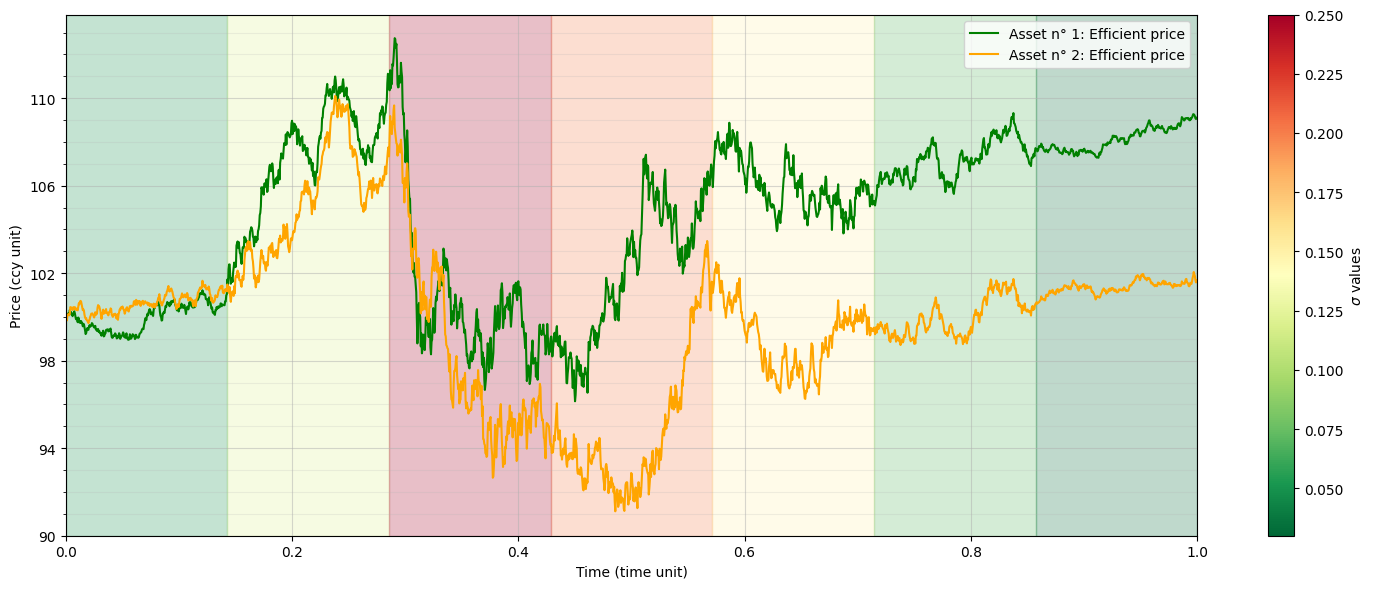

In [12]:
n_assets = 2

drift = .05
S0 = 100.
N = 2000
rho = 0.5
sigma = 0.2

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])

sigma_list = [.05,.12,.25,.20,.15,.07,.03]

covariance_matrix_sequence = []
for sigma in sigma_list:
  cov = rho * sigma * sigma
  covariance_matrix = np.eye(2) * sigma * sigma
  covariance_matrix[0,1] = cov
  covariance_matrix[1,0] = cov
  covariance_matrix_sequence.append(covariance_matrix)
covariance_matrix_sequence = np.array(covariance_matrix_sequence)
gen_prices = simulate_variable_volatility_brownian_motion(n_assets = n_assets,covariance_matrix_sequence = covariance_matrix_sequence,drift_vector = drift_vector,S0_vector = S0_vector, N_total=N)

colors = ["green","orange"]

tick_size = S0/ 100.
t_axis_array = np.array(range(len(gen_prices)))/len(gen_prices)

fig,ax = plt.subplots(1,1,figsize=(15,6))
for index,(raw_price,color) in enumerate(zip(gen_prices.T,colors)):
  ax.plot(t_axis_array,raw_price,color=color,label=f"Asset n° {index+1}: Efficient price")
ax.grid(True)
ax.set_ylabel("Price (ccy unit)")
ax.set_xlabel("Time (time unit)")

padding = 0.005
min_plot = gen_prices.min()*(1-padding)
min_plot = tick_size * min_plot//tick_size
max_plot = gen_prices.max()*(1+padding)
max_plot = tick_size * (max_plot+1)//tick_size
# Major ticks every 20, minor ticks every 5
major_ticks = np.arange( min_plot, max_plot , tick_size * 4)
minor_ticks = np.arange( min_plot, max_plot , tick_size)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

cmap = plt.get_cmap('RdYlGn').reversed()  # You can choose a different colormap if desired
norm = mcolors.Normalize(vmin=min(sigma_list), vmax=max(sigma_list))
grad_colors = [cmap(norm(value)) for value in sigma_list]

y_min,y_max = ax.get_ylim()
for index_sigma,(sigma,color) in enumerate(zip(sigma_list,grad_colors)):
  x_start = 1 / len(sigma_list) * index_sigma
  x_end = 1 / len(sigma_list) * (index_sigma+1)
  ax.fill([x_start, x_start, x_end, x_end], [y_min, y_max, y_max, y_min], color = color, alpha = 0.25)

ax.set_xlim((0,1))
ax.set_ylim((y_min,y_max))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,ax=ax)
cbar.set_label('$\sigma$ values')
ax.legend()

plt.tight_layout()

plt.show()

### Correlation estimator

In [13]:
def compute_rho_estimator_non_constant_vol(prices_bar: np.ndarray):

    log_returns_x = np.diff(np.log(prices_bar[:, 0]))
    log_returns_y = np.diff(np.log(prices_bar[:, 1]))

    cn_hat = np.sum(log_returns_x * log_returns_y)
    an_hat = np.sum(np.abs(np.roll(log_returns_x,1) * log_returns_y))
    an_hat = an_hat if an_hat!=0. else 1.
    
    rho_estimator = 2/np.pi * cn_hat / an_hat

    return rho_estimator

100%|██████████| 6/6 [01:31<00:00, 15.29s/it]


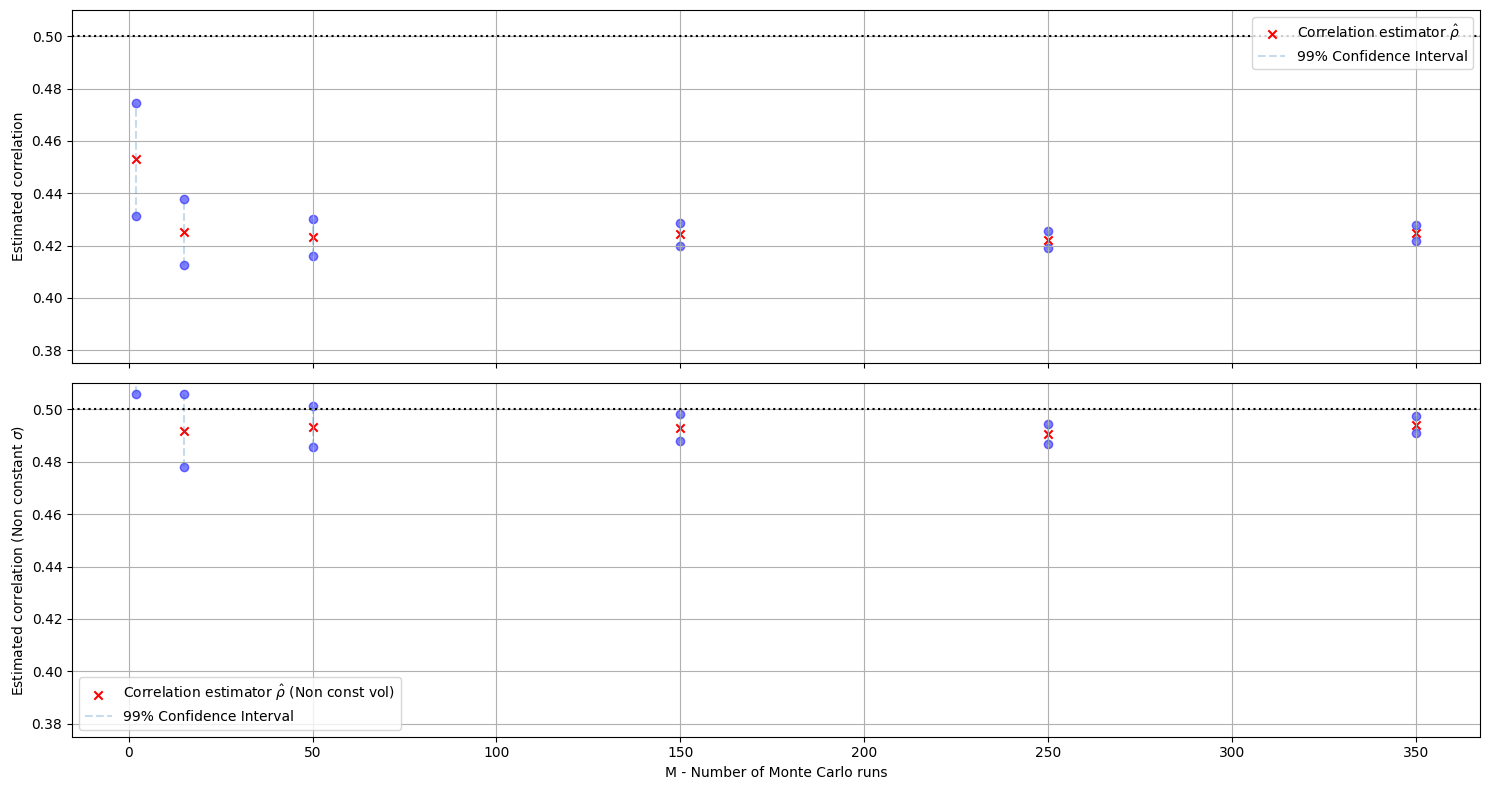

In [14]:
fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)

n_assets = 2

drift = .05
S0 = 100.
N = 5000
rho = 0.5
sigma = 0.2
tick_size = S0/ 500.
eta = 0.1

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])

sigma_list = [.05,.12,.25,.20,.15,.07,.03]

covariance_matrix_sequence = []
for sigma in sigma_list:
  cov = rho * sigma * sigma
  covariance_matrix = np.eye(2) * sigma * sigma
  covariance_matrix[0,1] = cov
  covariance_matrix[1,0] = cov
  covariance_matrix_sequence.append(covariance_matrix)
covariance_matrix_sequence = np.array(covariance_matrix_sequence)

N_sim_list = [2,15,50,150,250,350]

for N_sim in tqdm(N_sim_list):
  correl_hat = []
  correl_hat_non_const = []
  N_sim_sqrt = np.sqrt(N_sim)
  for _ in range(1,N_sim+1):

    gen_prices = simulate_variable_volatility_brownian_motion(n_assets = n_assets,covariance_matrix_sequence = covariance_matrix_sequence,drift_vector = drift_vector,S0_vector = S0_vector, N_total=N)
    ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)

    correl_hat.append(compute_rho_estimator_constant_volatility(ticked_prices))
    correl_hat_non_const.append(compute_rho_estimator_non_constant_vol(ticked_prices))

  plot_mc_on_ax(ax[0],correl_hat,N_sim,N_sim_sqrt,label="Correlation estimator $\hat{\\rho}$")
  plot_mc_on_ax(ax[1],correl_hat_non_const,N_sim,N_sim_sqrt,label="Correlation estimator $\hat{\\rho}$ (Non const vol)")


xmin,xmax = ax[0].get_xlim()
ax[0].hlines(y = rho,xmin = xmin,xmax = xmax,color = "black",linestyle=":")
ax[1].hlines(y = rho,xmin = xmin,xmax = xmax,color = "black",linestyle=":")

ax[0].set_xlim((xmin,xmax))
ax[0].set_ylim((rho*0.75,rho*1.02))
ax[1].set_ylim((rho*0.75,rho*1.02))
ax[0].set_ylabel("Estimated correlation")
ax[1].set_ylabel("Estimated correlation (Non constant $\sigma$)")
ax[1].set_xlabel("M - Number of Monte Carlo runs")
ax[0].grid(True)
ax[1].grid(True)

plt.tight_layout()
plt.show()

## The Epps Effect :  the previous tick estimator

In [15]:
def vh_estimator(prices_bar: np.ndarray, h: float):
    """
    prices_bar : shape Nx2 containing floats
    h : float (of order 0.001-0.1)
    """
    m = int(1 / h)
    N = len(prices_bar)
    time_sampling = np.arange(0, m) / m

    i1 = (N * time_sampling).astype(int)
    i2 = (N * (time_sampling - h)).astype(int)

    log_prices = np.log(prices_bar)

    log_ret_x = log_prices[i1, 0] - log_prices[i2, 0]
    log_ret_y = log_prices[i1, 1] - log_prices[i2, 1]

    vh = np.sum(log_ret_x * log_ret_y)

    return vh

100%|██████████| 8/8 [05:09<00:00, 38.71s/it]


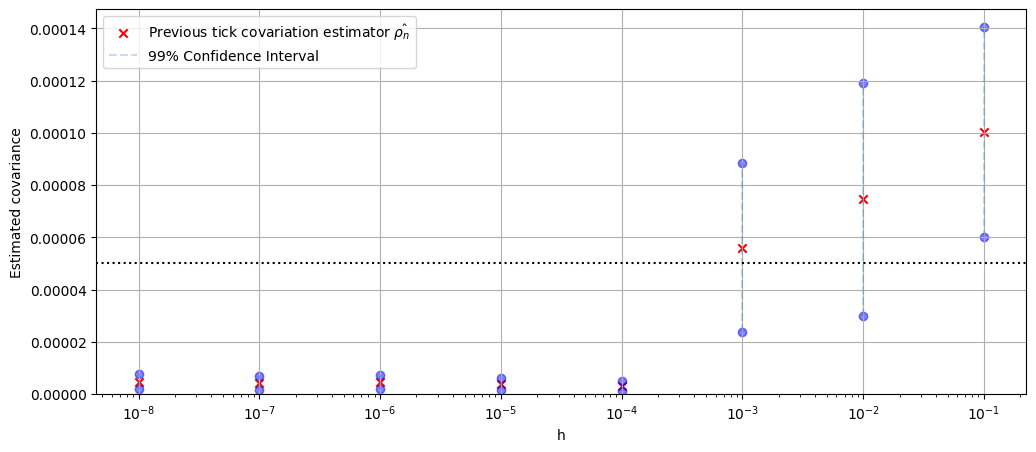

In [16]:
n_assets = 2

drift = .0
S0 = 100.
N = 1000
rho = 0.5
sigma = 0.01
cov = sigma * sigma * rho

tick_size = S0/ 250.
eta = 0.25

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

fig,ax = plt.subplots(1,1,figsize=(12,5))

N_sim = 100
N_sim_sqrt = np.sqrt(N_sim)
h_list = [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]

for h in tqdm(h_list):
  vh_hat = []
  for _ in range(N_sim):
    gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix,drift_vector = drift_vector,S0_vector = S0_vector, N=N)
    ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)
    vh_hat.append(vh_estimator(ticked_prices, h))

  plot_mc_on_ax(ax,vh_hat,h,N_sim_sqrt,"Previous tick covariation estimator $\hat{\\rho_n}$")

ax.set_xscale("log")
x_min,x_max = ax.get_xlim()
ax.hlines(y = cov,xmin = x_min,xmax = x_max, color="black",linestyle=":",label = f"Simulation covariance {cov:.2f}")
ax.set_xlim((x_min,x_max))
ax.set_xlabel("h")
_,ylim = ax.get_ylim()
ax.set_ylim((0,ylim))
ax.grid(True)
ax.set_ylabel("Estimated covariance")
plt.show()

# Hayashi-Yoshida estimator

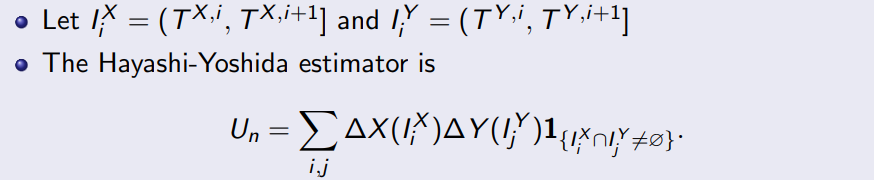

In [16]:
def unpack_observed_price(prices_bar : np.ndarray):
  observed_time_price_tuple_X = [(0,prices_bar[0,0])]
  observed_time_price_tuple_Y = [(0,prices_bar[0,1])]

  for step in range(1,len(prices_bar)):

    if prices_bar[step,0]!=observed_time_price_tuple_X[-1][1]:
      observed_time_price_tuple_X.append((step,prices_bar[step,0]))
    if prices_bar[step,1]!=observed_time_price_tuple_Y[-1][1]:
      observed_time_price_tuple_Y.append((step,prices_bar[step,1]))

  return observed_time_price_tuple_X,observed_time_price_tuple_Y

In [17]:
def get_efficient_price_from_unpacked_observed_price(observed_price : list,tick_size :float,eta : float):
    efficient_price = []
    n = len(observed_price)
    for index in range(1,n):

      t_i,p_i = observed_price[index]
      _,p_i_1 = observed_price[index-1]

      ef_p_i = p_i - tick_size * (1/2 - eta) * np.sign(p_i-p_i_1)
      efficient_price.append((t_i,ef_p_i))

    return efficient_price

In [18]:
def compute_hayashi_yoshida_estimator(observed_time_price_tuple_X,observed_time_price_tuple_Y):

  U_n = 0
  T = min(len(observed_time_price_tuple_Y),len(observed_time_price_tuple_X))

  for index_x in range(0,T-1):

    t_x_start,p_x_start = observed_time_price_tuple_X[index_x]
    t_x_end,p_x_end = observed_time_price_tuple_X[index_x+1]

    index_y = 0

    while observed_time_price_tuple_Y[index_y][0] < t_x_end and index_y<T-2: #start of Y isn't after end of X

      t_y_start,p_y_start = observed_time_price_tuple_Y[index_y]
      t_y_end,p_y_end = observed_time_price_tuple_Y[index_y+1]

      if t_y_end > t_x_start:

        U_n += np.log(p_x_end/p_x_start) * np.log(p_y_end/p_y_start)

      index_y +=1

  return U_n

## Uncorrected

In [19]:
n_assets = 2

drift = .05
S0 = 100.
N = 1500
rho = 0.75
sigma = 0.35
cov = sigma * sigma * rho

tick_size = 0.01
eta = 0.2

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

N_sim_list= [5,15,50,150,500]

print(f"Target covariance is : {cov:.4f}")
print("============================")
for n_sim in N_sim_list:
  hy_list = []
  for _ in range(n_sim):
    gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix,drift_vector = drift_vector,S0_vector = S0_vector, N=N)
    ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)
    observed_time_price_tuple_X,observed_time_price_tuple_Y = unpack_observed_price(ticked_prices)
    hy_estimator = compute_hayashi_yoshida_estimator(observed_time_price_tuple_X,observed_time_price_tuple_Y)
    hy_list.append(hy_estimator)

  hy_mean = np.mean(hy_list)
  hy_std = np.std(hy_list)

  print(f"Hayashi-Yoshida estimator : {hy_mean:.5f}±{hy_std:.5f} ({(hy_mean-cov)/cov*100:.2f}% error for {n_sim} runs)")
  

Target covariance is : 0.0919
Hayashi-Yoshida estimator : 0.09115±0.00264 (-0.78% error for 5 runs)
Hayashi-Yoshida estimator : 0.09066±0.00286 (-1.33% error for 15 runs)
Hayashi-Yoshida estimator : 0.09334±0.00423 (1.60% error for 50 runs)
Hayashi-Yoshida estimator : 0.09214±0.00423 (0.29% error for 150 runs)
Hayashi-Yoshida estimator : 0.09239±0.00387 (0.56% error for 500 runs)


## Corrected

In [20]:
n_assets = 2

drift = .05
S0 = 100.
N = 1500
rho = 0.75
sigma = 0.35
cov = sigma * sigma * rho

tick_size = 0.01
eta = 0.2

drift_vector = np.array([drift,drift])
S0_vector = np.array([S0,S0])
covariance_matrix = np.eye(2) * sigma * sigma
covariance_matrix[0,1] = cov
covariance_matrix[1,0] = cov

N_sim_list= [5,15,50,150,500]

print(f"Target covariance is : {cov:.4f}")
print("============================")
for n_sim in N_sim_list:
  hy_list = []
  for _ in range(n_sim):
    gen_prices = generate_one_path_multiple_assets(n_assets = n_assets,covariance_matrix = covariance_matrix\
                                                   ,drift_vector = drift_vector,S0_vector = S0_vector, N=N)
    ticked_prices = get_observed_price_from_theoritical_price(gen_prices,tick_size,eta)

    observed_time_price_tuple_X,observed_time_price_tuple_Y = unpack_observed_price(ticked_prices)
    efficient_time_price_tuple_X = get_efficient_price_from_unpacked_observed_price(observed_time_price_tuple_X,tick_size,eta)
    efficient_time_price_tuple_Y = get_efficient_price_from_unpacked_observed_price(observed_time_price_tuple_Y,tick_size,eta)

    hy_estimator = compute_hayashi_yoshida_estimator(efficient_time_price_tuple_X,efficient_time_price_tuple_Y)
    hy_list.append(hy_estimator)

  hy_mean = np.mean(hy_list)
  hy_std = np.std(hy_list)

  print(f"Hayashi-Yoshida estimator : {hy_mean:.5f}±{hy_std:.5f} ({(hy_mean-cov)/cov*100:.2f}% error for {n_sim} runs)")
  

Target covariance is : 0.0919
Hayashi-Yoshida estimator : 0.09215±0.00517 (0.30% error for 5 runs)
Hayashi-Yoshida estimator : 0.09102±0.00333 (-0.93% error for 15 runs)
Hayashi-Yoshida estimator : 0.09170±0.00401 (-0.19% error for 50 runs)
Hayashi-Yoshida estimator : 0.09223±0.00366 (0.38% error for 150 runs)
Hayashi-Yoshida estimator : 0.09188±0.00387 (0.00% error for 500 runs)
